This is a tutorial on variational autoencoders
The data set used here is MNIST

In [0]:
import numpy as np
import pandas as pd
%tensorflow_version 1.x
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

TensorFlow is already loaded. Please restart the runtime to change versions.


taking input as tensorflow dataset

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')
# data = mnist.train.images
# labels = np.asarray(mnist.train.labels, dtype=np.int32)
# test_data = mnist.test.images
# test_labels = np.asarray(mnist.test.labels, dtype = np.int32)
# arr=np.reshape(data,(55000,28,28))

# plt.imshow(arr[1].astype(np.float32), cmap=plt.get_cmap("gray"))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


MNIST images have a dimension of 28 * 28 pixels with one color channel. Our inputs X_in will be batches of MNIST characters. The network will learn to reconstruct them and output them in a placeholder Y, which has the same dimensions.
Y_flat will be used later, when computing losses. keep_prob will be used when applying dropouts as a means of regularization. During training, it will have a value of 0.8. When generating new data, we won’t apply dropout, so the value will be 1.
The function lrelu is being defined, as Tensorflow unfortunately doesn’t come up with a predefined leaky ReLU.

In [0]:
tf.reset_default_graph()
batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')



dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder=24
#inputs_decoder = 49 * dec_in_channels / 2


def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))




**Defining the encoder**


As our inputs are images, it’s most reasonable to apply some convolutional transformations to them. What’s most noteworthy is the fact that we are creating two vectors in our encoder, as the encoder is supposed to create objects following a Gaussian Distribution:
A vector of means
A vector of standard deviations
You will see later how we “force” the encoder to make sure it really creates values following a Normal Distribution. The returned values that will be fed to the decoder are the z-values. We will need the mean and standard deviation of our distributions later, when computing losses.



In [0]:
def encoder(X_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd       = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        
        return z, mn, sd

**Defining the decoder**


The decoder does not care about whether the input values are sampled from some specific distribution that has been defined by us. It simply will try to reconstruct the input images. To this end, we use a series of transpose convolutions.

In [0]:
def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=lrelu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

In [0]:

sampled, mn, sd = encoder(X_in, keep_prob)
dec = decoder(sampled, keep_prob)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.


**Computing losses and enforcing a Gaussian latent distribution**


For computing the image reconstruction loss, we simply use squared difference (which could lead to images sometimes looking a bit fuzzy). This loss is combined with the Kullback-Leibler divergence, which makes sure our latent values will be sampled from a normal distribution. For more on this topic, please take a look a Jaan Altosaar’s great article on VAEs.

In [0]:

unreshaped = tf.reshape(dec, [-1, 28*28])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**Training the network**


Now, we can finally train our VAE!
Every 200 steps, we’ll take a look at what the current reconstructions look like. After having processed about 2000 batches, most reconstructions will look reasonable.


In [0]:

for i in range(3000):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    #arr=np.array([np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]])
    # arr=batch
    sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})
        
    # if not i % 200:
    #     ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
    #     plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
    #     plt.show()
    #     plt.imshow(d[0], cmap='gray')
    #     plt.show()
    #     print(i, ls, np.mean(i_ls), np.mean(d_ls))

TypeError: ignored

In [0]:
mnist.train.next_batch(batch_size=batch_size)[0].shape
arr=np.array([np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]])
print(arr.shape)

(64, 28, 28)


In [0]:
randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


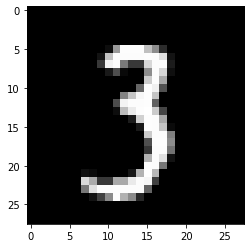

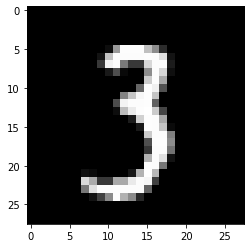

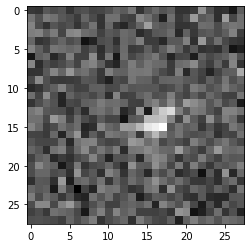

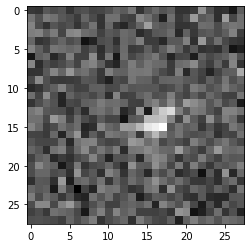

0 177.98297 177.97939 0.0035837023
0 177.98297 177.97939 0.0035837023


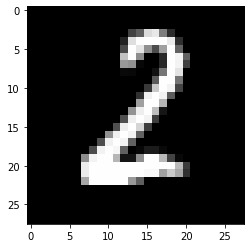

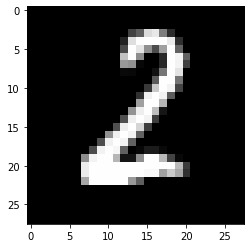

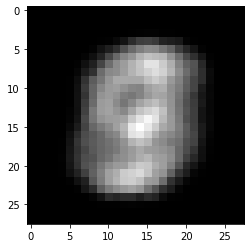

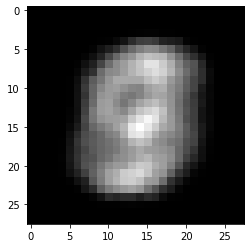

100 52.892204 52.16327 0.72893405
100 52.892204 52.16327 0.72893405


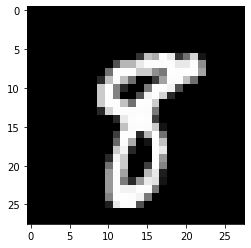

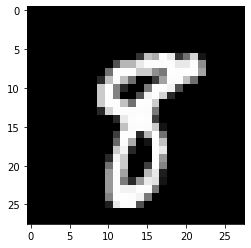

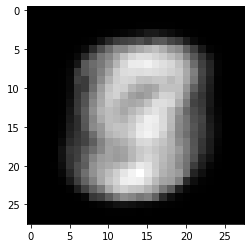

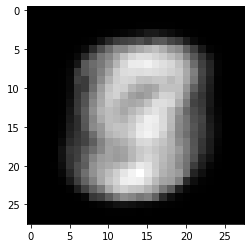

200 49.168854 47.57724 1.5916089
200 49.168854 47.57724 1.5916089


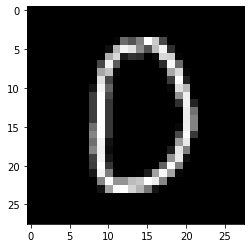

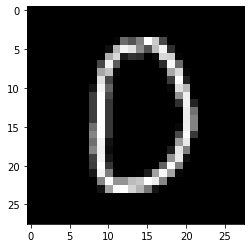

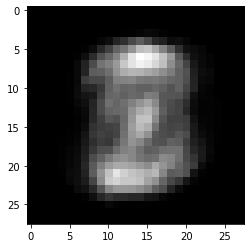

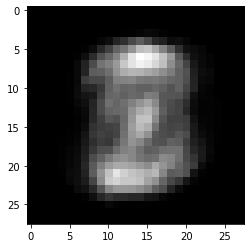

300 46.32332 42.9767 3.3466172
300 46.32332 42.9767 3.3466172


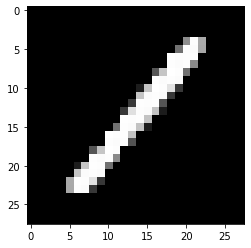

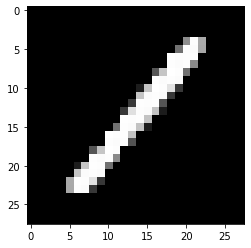

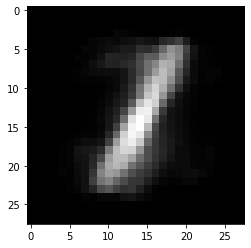

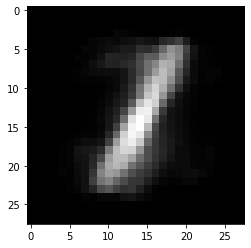

400 40.388943 34.805832 5.583112
400 40.388943 34.805832 5.583112


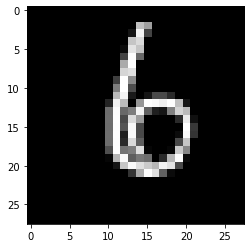

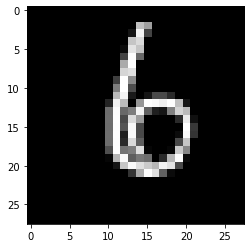

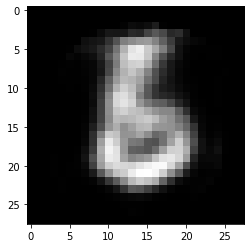

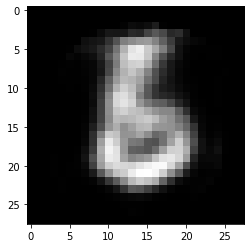

500 34.952133 28.307991 6.6441402
500 34.952133 28.307991 6.6441402


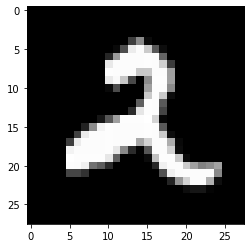

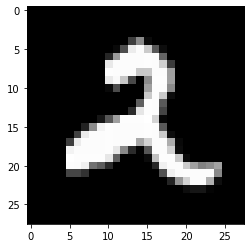

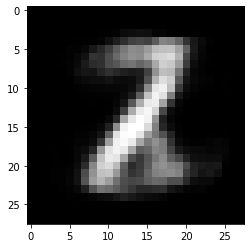

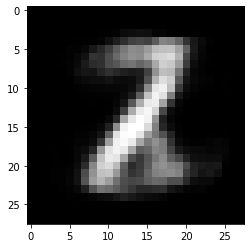

600 37.908348 30.113033 7.795318
600 37.908348 30.113033 7.795318


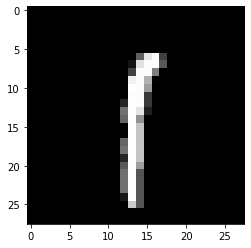

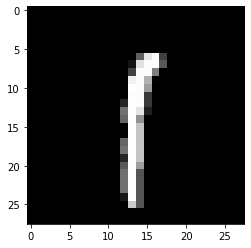

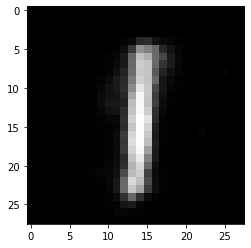

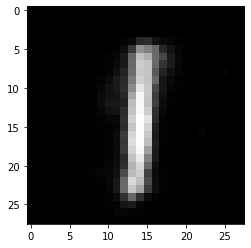

700 35.2701 27.150326 8.119775
700 35.2701 27.150326 8.119775


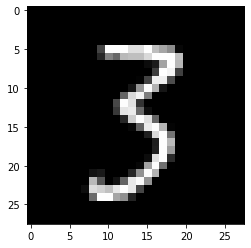

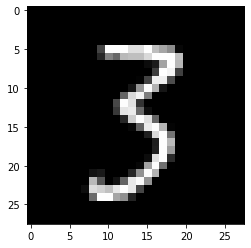

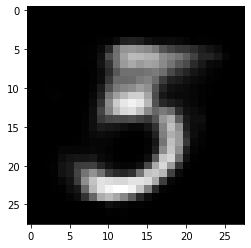

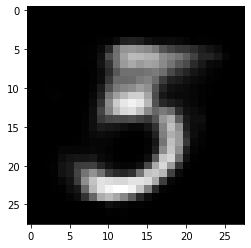

800 36.058376 27.496143 8.562232
800 36.058376 27.496143 8.562232


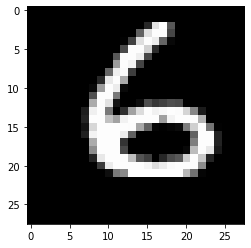

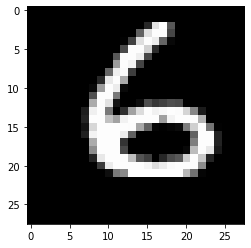

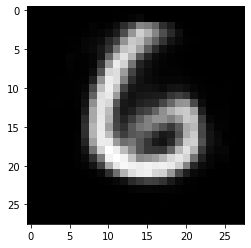

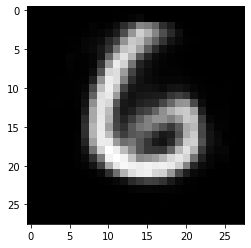

900 32.237865 23.869667 8.368202
900 32.237865 23.869667 8.368202


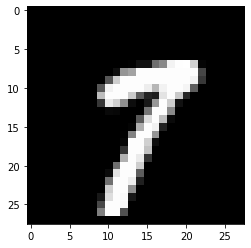

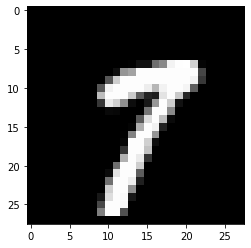

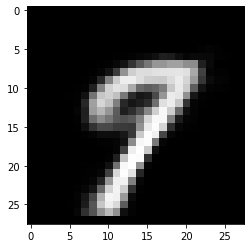

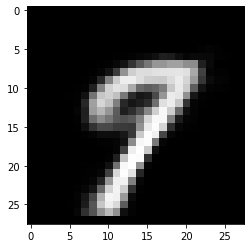

1000 32.513832 24.29641 8.2174225
1000 32.513832 24.29641 8.2174225


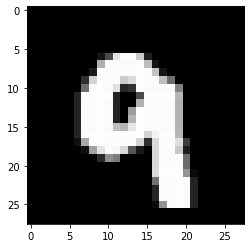

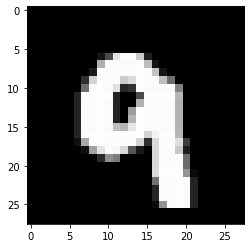

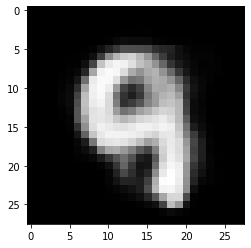

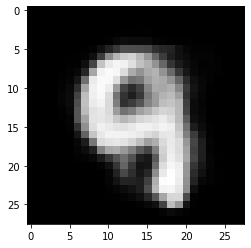

1100 30.620434 22.321238 8.299196
1100 30.620434 22.321238 8.299196


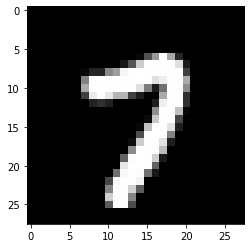

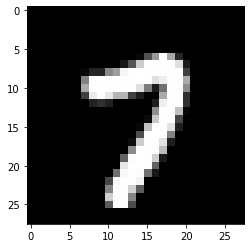

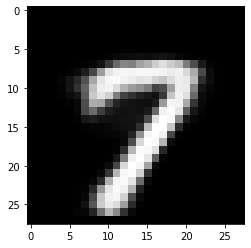

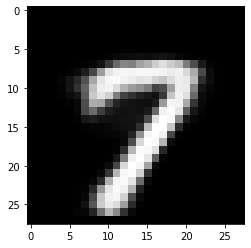

1200 30.029415 21.632248 8.397167
1200 30.029415 21.632248 8.397167


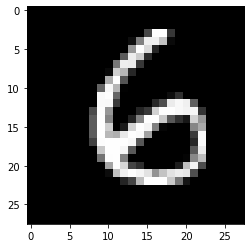

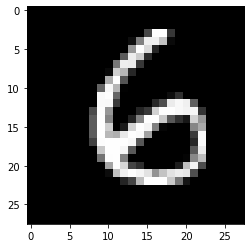

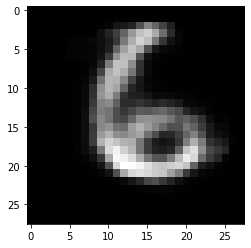

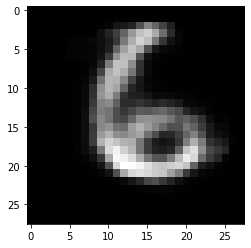

1300 32.348827 23.9021 8.446724
1300 32.348827 23.9021 8.446724


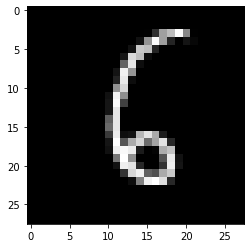

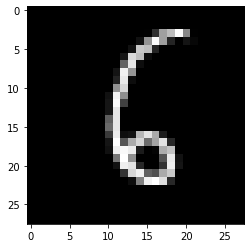

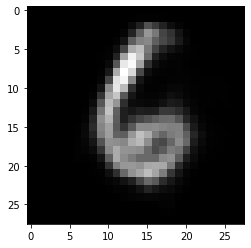

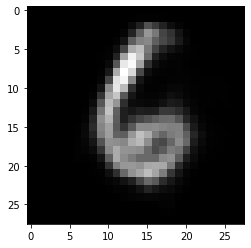

1400 32.447754 23.680748 8.767012
1400 32.447754 23.680748 8.767012


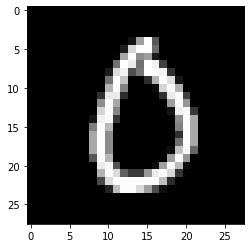

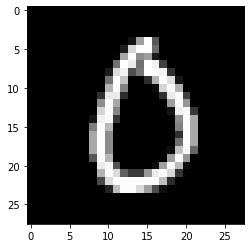

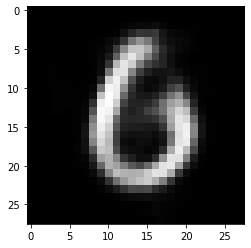

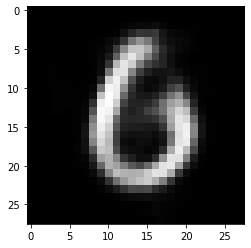

1500 32.058273 22.86611 9.192165
1500 32.058273 22.86611 9.192165


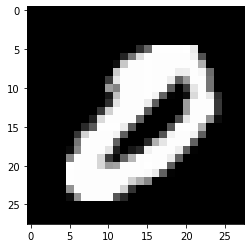

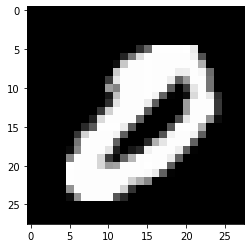

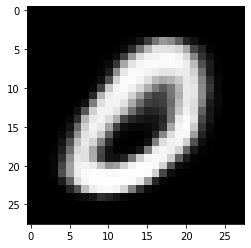

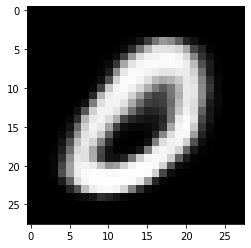

1600 32.548862 23.205616 9.343245
1600 32.548862 23.205616 9.343245


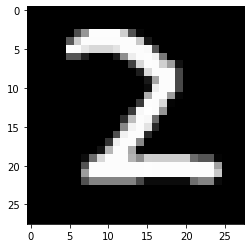

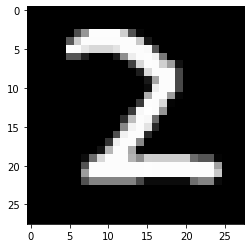

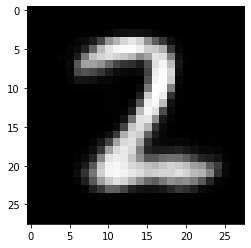

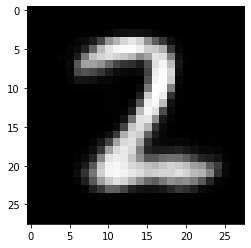

1700 31.695137 22.919533 8.7756
1700 31.695137 22.919533 8.7756


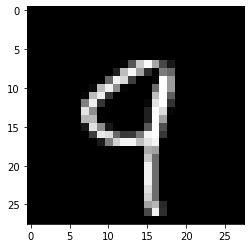

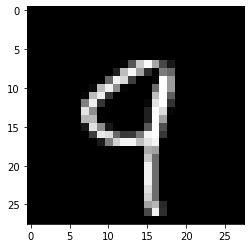

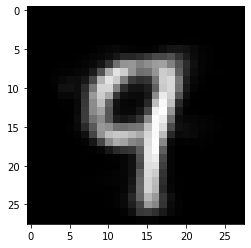

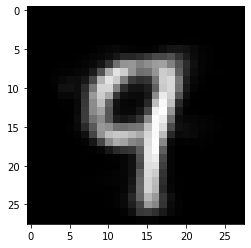

1800 31.155464 22.157536 8.997929
1800 31.155464 22.157536 8.997929


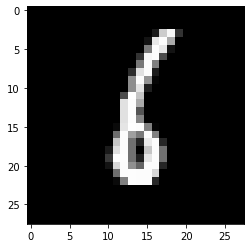

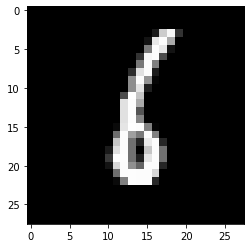

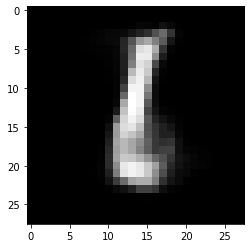

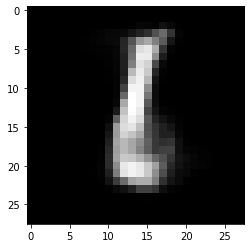

1900 30.75259 21.163883 9.588707
1900 30.75259 21.163883 9.588707


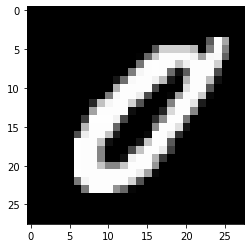

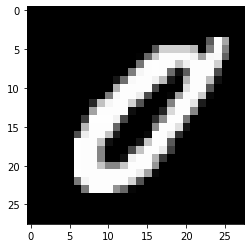

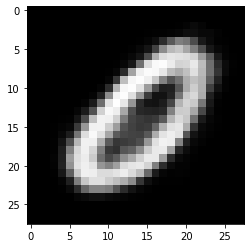

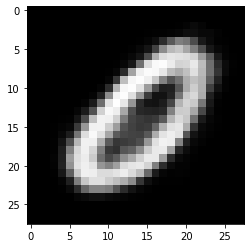

2000 30.485134 21.391945 9.09319
2000 30.485134 21.391945 9.09319


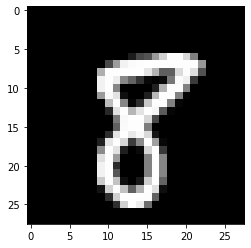

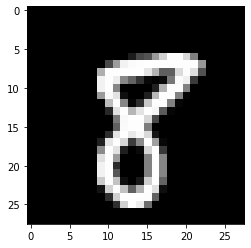

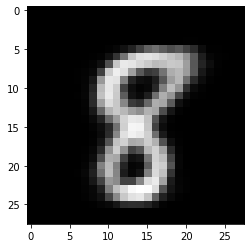

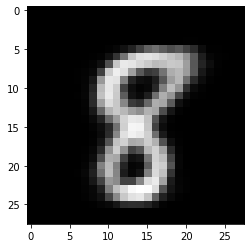

2100 32.932228 23.14435 9.787874
2100 32.932228 23.14435 9.787874


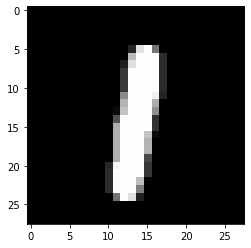

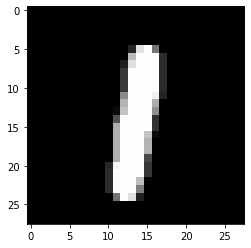

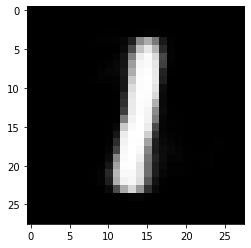

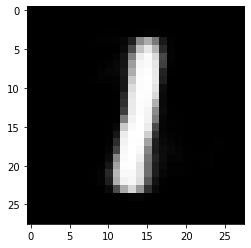

2200 30.076107 20.775465 9.300641
2200 30.076107 20.775465 9.300641


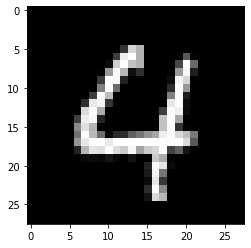

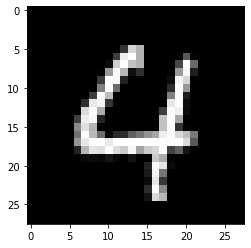

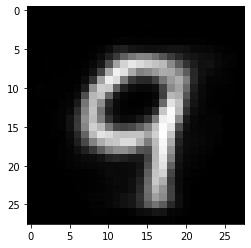

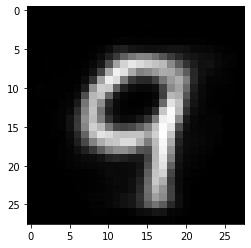

2300 31.970049 22.39901 9.57104
2300 31.970049 22.39901 9.57104


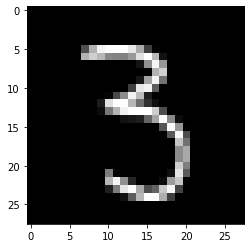

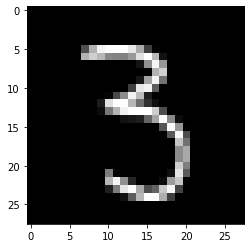

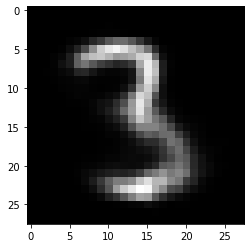

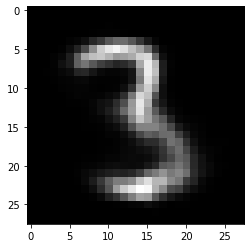

2400 33.07968 23.809639 9.270039
2400 33.07968 23.809639 9.270039


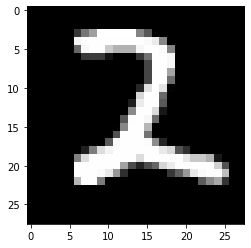

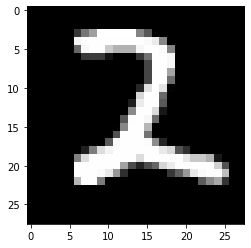

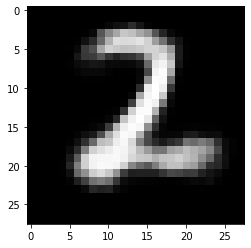

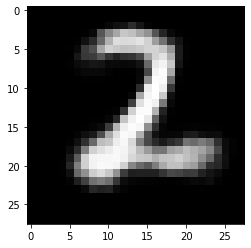

2500 29.613012 20.284592 9.328421
2500 29.613012 20.284592 9.328421


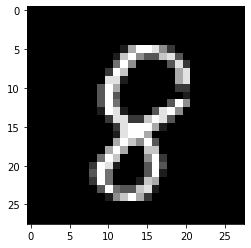

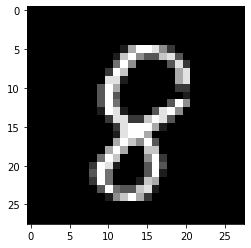

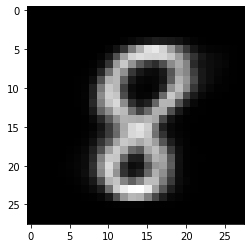

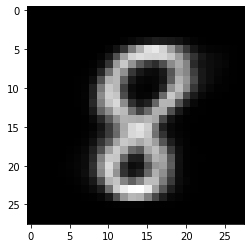

2600 31.128965 21.218042 9.910925
2600 31.128965 21.218042 9.910925


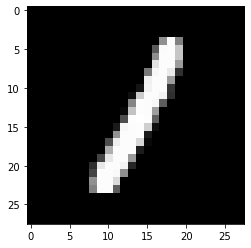

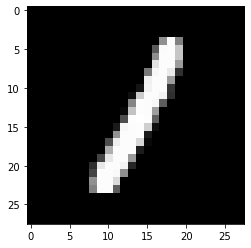

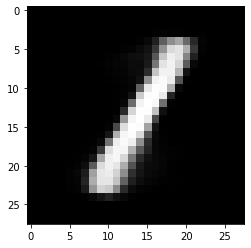

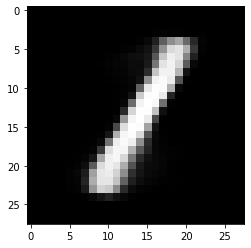

2700 29.745932 20.543716 9.202213
2700 29.745932 20.543716 9.202213


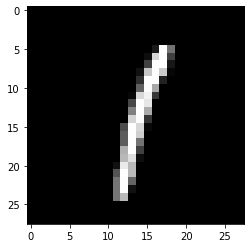

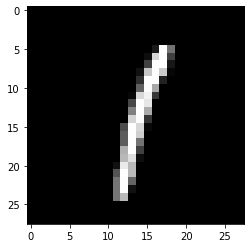

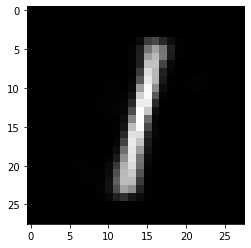

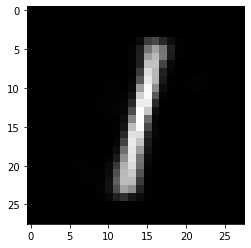

2800 30.304298 20.874432 9.429867
2800 30.304298 20.874432 9.429867


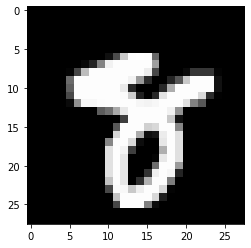

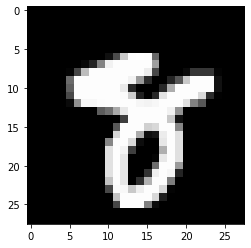

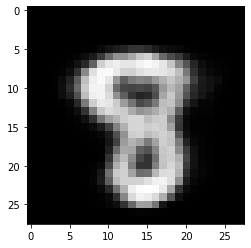

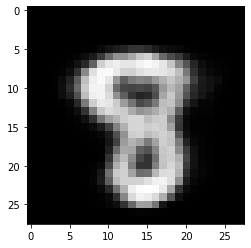

2900 30.342394 20.561628 9.780765
2900 30.342394 20.561628 9.780765


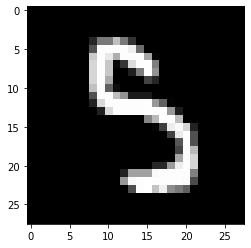

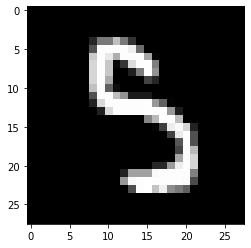

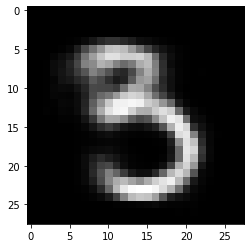

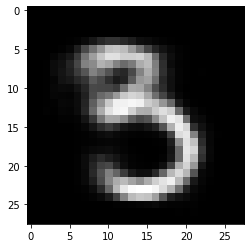

3000 30.960875 21.130999 9.829876
3000 30.960875 21.130999 9.829876


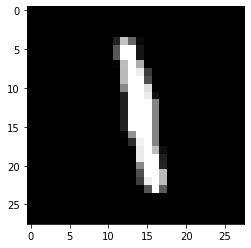

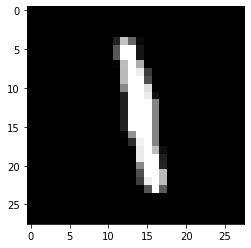

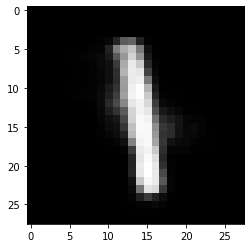

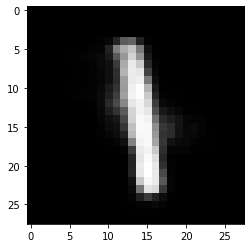

3100 29.852917 20.337473 9.515444
3100 29.852917 20.337473 9.515444


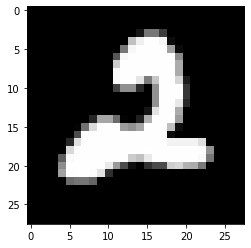

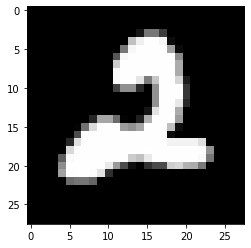

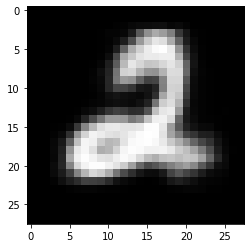

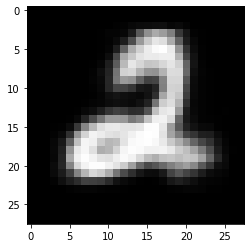

3200 32.80711 22.86596 9.941151
3200 32.80711 22.86596 9.941151


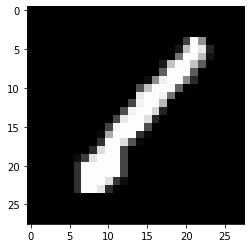

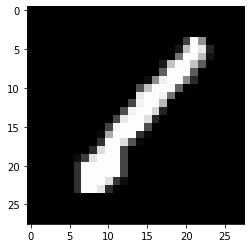

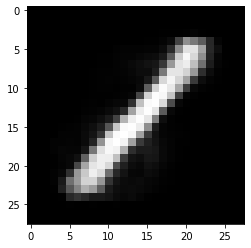

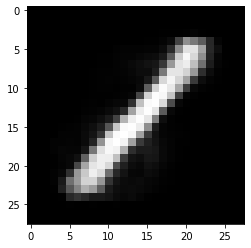

3300 27.96611 18.489841 9.476267
3300 27.96611 18.489841 9.476267


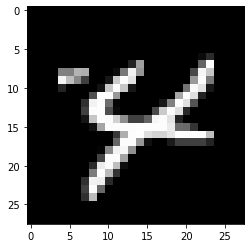

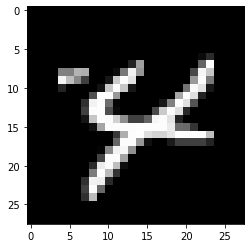

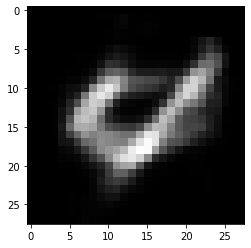

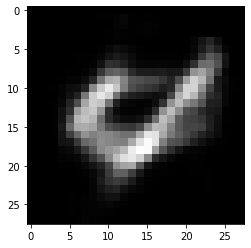

3400 31.158108 21.779366 9.378743
3400 31.158108 21.779366 9.378743


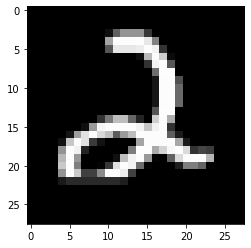

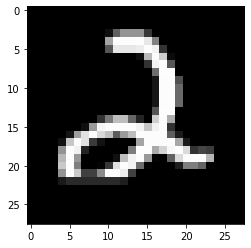

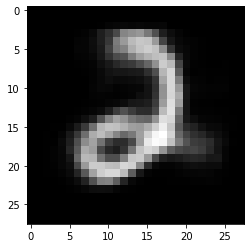

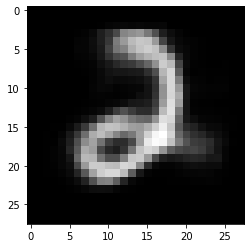

3500 30.32531 20.74179 9.583519
3500 30.32531 20.74179 9.583519


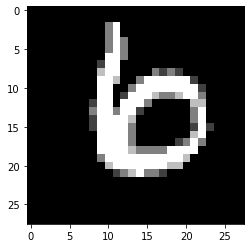

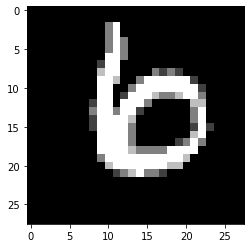

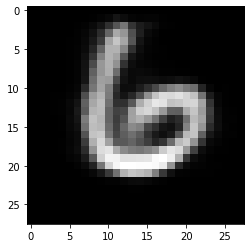

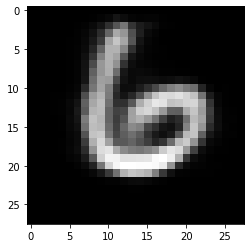

3600 30.283554 20.485283 9.798272
3600 30.283554 20.485283 9.798272


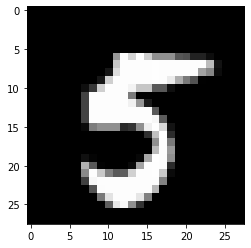

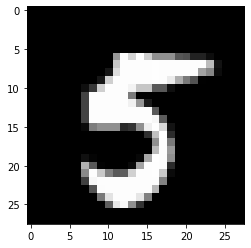

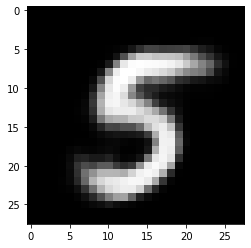

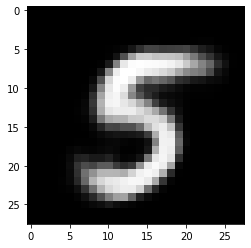

3700 31.019032 21.490273 9.528757
3700 31.019032 21.490273 9.528757


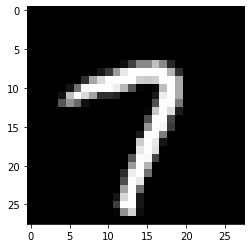

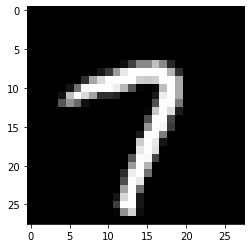

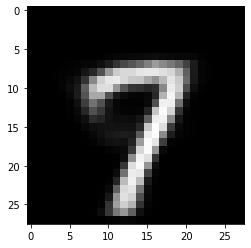

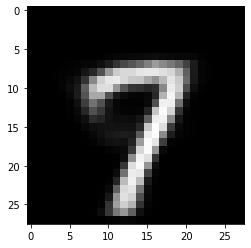

3800 29.995207 20.44674 9.54847
3800 29.995207 20.44674 9.54847


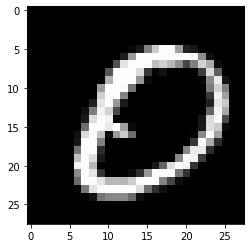

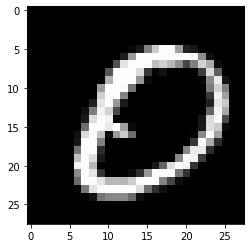

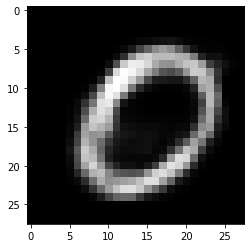

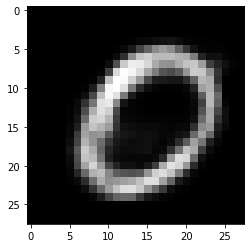

3900 31.483513 22.059057 9.424454
3900 31.483513 22.059057 9.424454


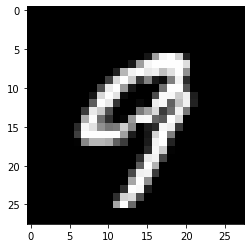

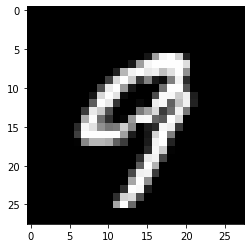

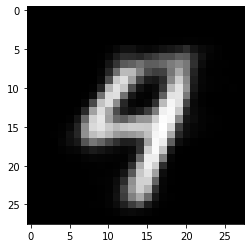

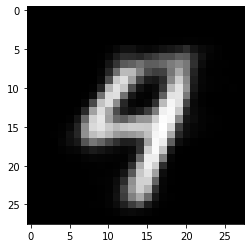

4000 31.66325 21.480663 10.182586
4000 31.66325 21.480663 10.182586


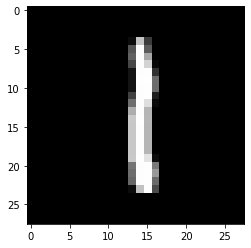

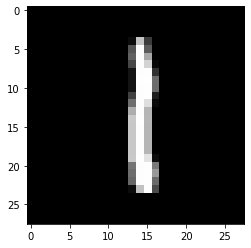

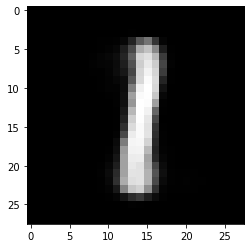

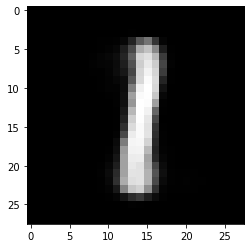

4100 27.562853 18.107075 9.45578
4100 27.562853 18.107075 9.45578


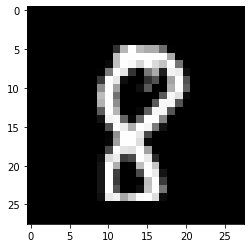

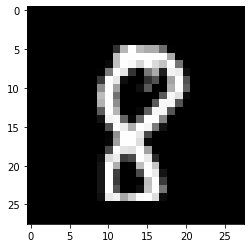

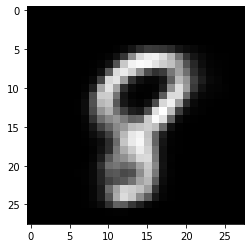

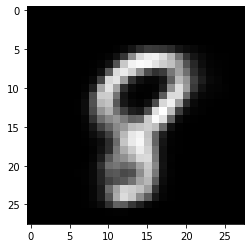

4200 27.883995 18.34799 9.536005
4200 27.883995 18.34799 9.536005


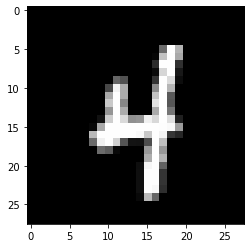

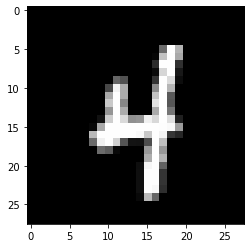

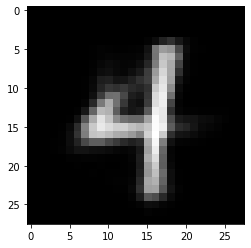

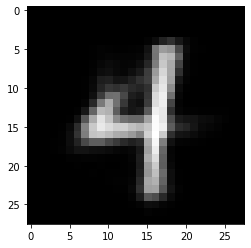

4400 29.205275 18.907364 10.297911
4400 29.205275 18.907364 10.297911


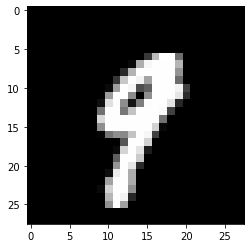

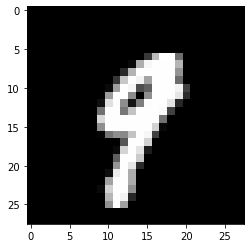

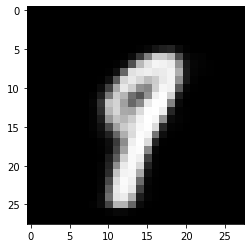

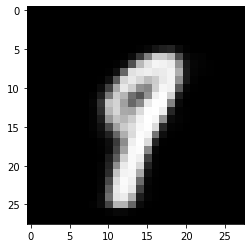

4500 28.793106 19.142632 9.6504755
4500 28.793106 19.142632 9.6504755


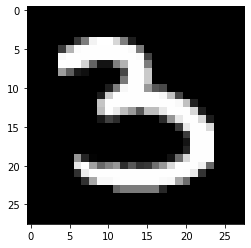

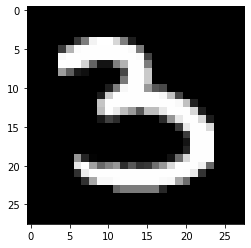

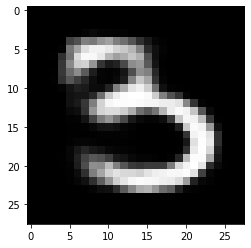

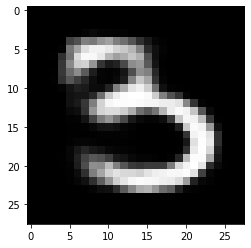

4600 27.696426 17.456228 10.2402
4600 27.696426 17.456228 10.2402


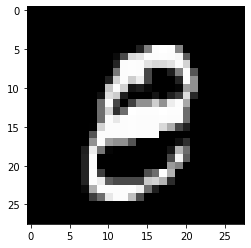

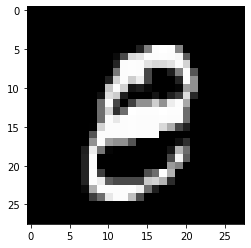

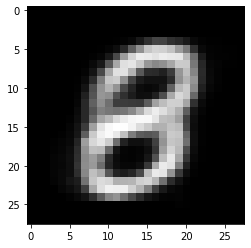

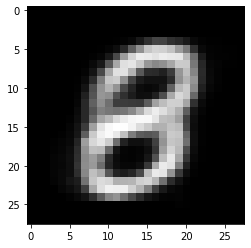

4700 30.973808 21.04961 9.924198
4700 30.973808 21.04961 9.924198


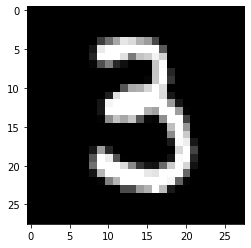

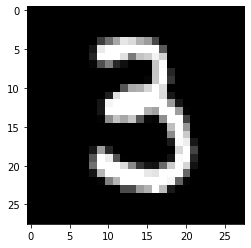

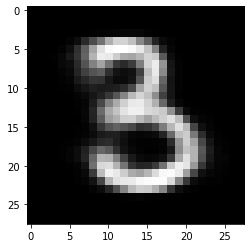

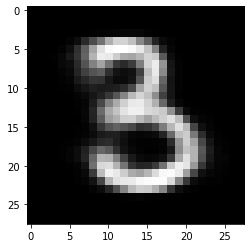

4800 28.95789 19.211128 9.746763
4800 28.95789 19.211128 9.746763


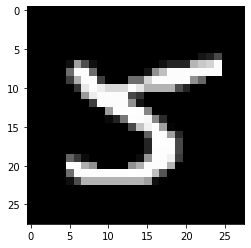

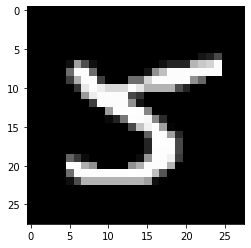

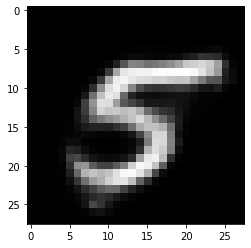

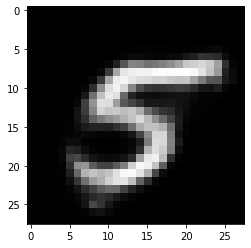

4900 28.263905 18.179302 10.084603
4900 28.263905 18.179302 10.084603


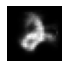

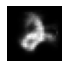

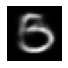

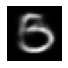

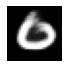

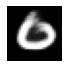

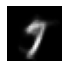

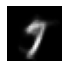

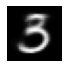

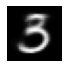

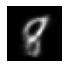

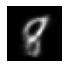

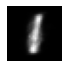

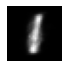

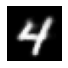

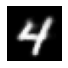

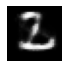

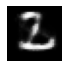

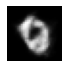

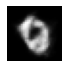

In [0]:
# Skip to content
# Search or jump to…

# Pull requests
# Issues
# Marketplace
# Explore
 
# @pritam004 
# Learn Git and GitHub without any code!
# Using the Hello World guide, you’ll start a branch, write comments, and open a pull request.


# KKDeng
# /
# tensorflow
# 0
# 00
#  Code Issues 0 Pull requests 0 Actions Projects 0 Wiki Security Insights
# tensorflow/vae
# @KKDeng KKDeng Create vae
# b1caa13 on 16 Jul 2018
# 103 lines (77 sloc)  3.79 KB
 
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt
#matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')





tf.reset_default_graph()

batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 24
#inputs_decoder = 49 * dec_in_channels / 2


def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))


def encoder(X_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd = 0.5 * tf.layers.dense(x, units=n_latent)
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent]))
        z = mn + tf.multiply(epsilon, tf.exp(sd))

    return z, mn, sd


def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=lrelu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)

        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28 * 28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
    return img


sampled, mn, sd = encoder(X_in, keep_prob)
dec = decoder(sampled, keep_prob)


unreshaped = tf.reshape(dec, [-1, 28*28])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(5000):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    sess.run(optimizer, feed_dict={X_in: batch, Y: batch, keep_prob: 0.8})

    if not i % 100:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd],
                                               feed_dict={X_in: batch, Y: batch, keep_prob: 1.0})
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        plt.show()
        plt.imshow(d[0], cmap='gray')
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))

randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plt.show()
# © 2020 GitHub, Inc.
# Terms
# Privacy
# Security
# Status
# Help
# Contact GitHub
# Pricing
# API
# Training
# Blog
# About
